# About Dataset
Description:

The Dangerous Farm Insects Image Dataset is a curated collection of images featuring 15 different types of insects commonly found in agricultural settings. This dataset provides valuable visual resources for studying, identifying, and understanding the characteristics of these potentially harmful insects. Each insect is represented by multiple high-quality images, showcasing their distinct features, colors, and patterns.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

C:\Users\wmigu\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Load Data

In [23]:
# Load data
data_dir = 'Images'
labels = os.listdir(data_dir)

import pathlib
data_dir = pathlib.Path('Images')
all_images = list(data_dir.glob('*/*.jpg'))

# Check number of images
print('Number of images found: ', len(all_images))
print('Number of labels found: ', len(labels))

Number of images found:  1464
Number of labels found:  15


In [24]:
# Create dataframe
df = pd.DataFrame(all_images, columns=['image'])
df['label'] = df['image'].map(lambda x: os.path.split(os.path.split(x)[0])[1])
df.head()

,image,label
0,Images\Africanized Honey Bees (Killer Bees)\Im...,Africanized Honey Bees (Killer Bees)
1,Images\Africanized Honey Bees (Killer Bees)\Im...,Africanized Honey Bees (Killer Bees)
2,Images\Africanized Honey Bees (Killer Bees)\Im...,Africanized Honey Bees (Killer Bees)
3,Images\Africanized Honey Bees (Killer Bees)\Im...,Africanized Honey Bees (Killer Bees)
4,Images\Africanized Honey Bees (Killer Bees)\Im...,Africanized Honey Bees (Killer Bees)


In [25]:
# Check number of images per label
df['label'].value_counts()

Spider Mites                            112
Tomato Hornworms                        107
Colorado Potato Beetles                 106
Brown Marmorated Stink Bugs             105
Fall Armyworms                          104
Citrus Canker                           101
Corn Earworms                           100
Thrips                                   97
Corn Borers                              96
Fruit Flies                              94
Armyworms                                92
Africanized Honey Bees (Killer Bees)     91
Cabbage Loopers                          91
Western Corn Rootworms                   87
Aphids                                   81
Name: label, dtype: int64

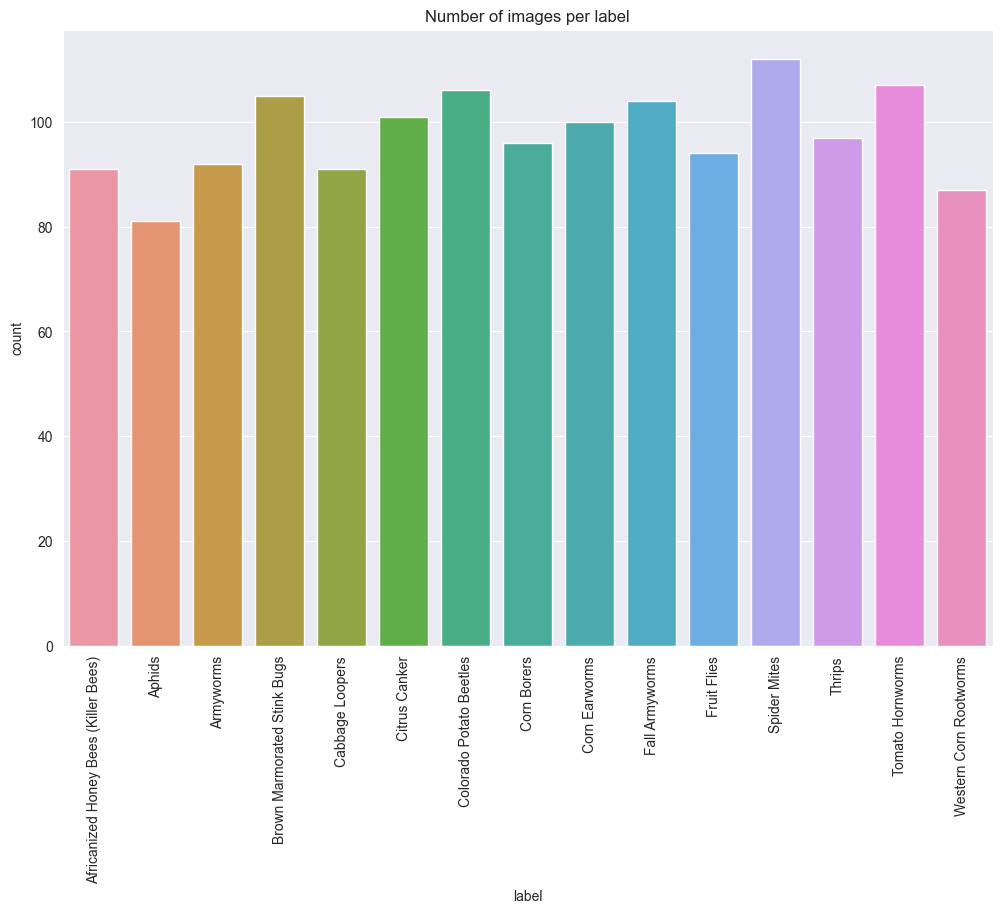

In [26]:
# Plot number of images per label
plt.figure(figsize=(12, 8))
sns.countplot(x='label', data=df)
plt.xticks(rotation=90)
plt.title('Number of images per label')
plt.show()


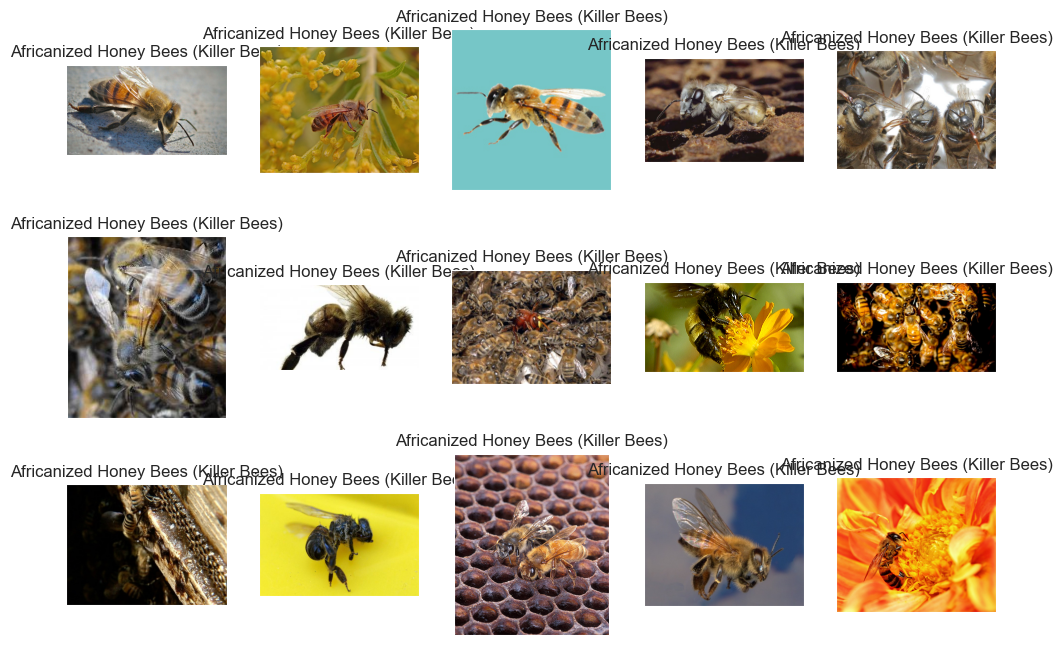

In [27]:
# Plot sample images
plt.figure(figsize=(12, 8))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(Image.open(str(df['image'][i])))
    plt.title(df['label'][i])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [28]:
# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0, stratify=df['label'])
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


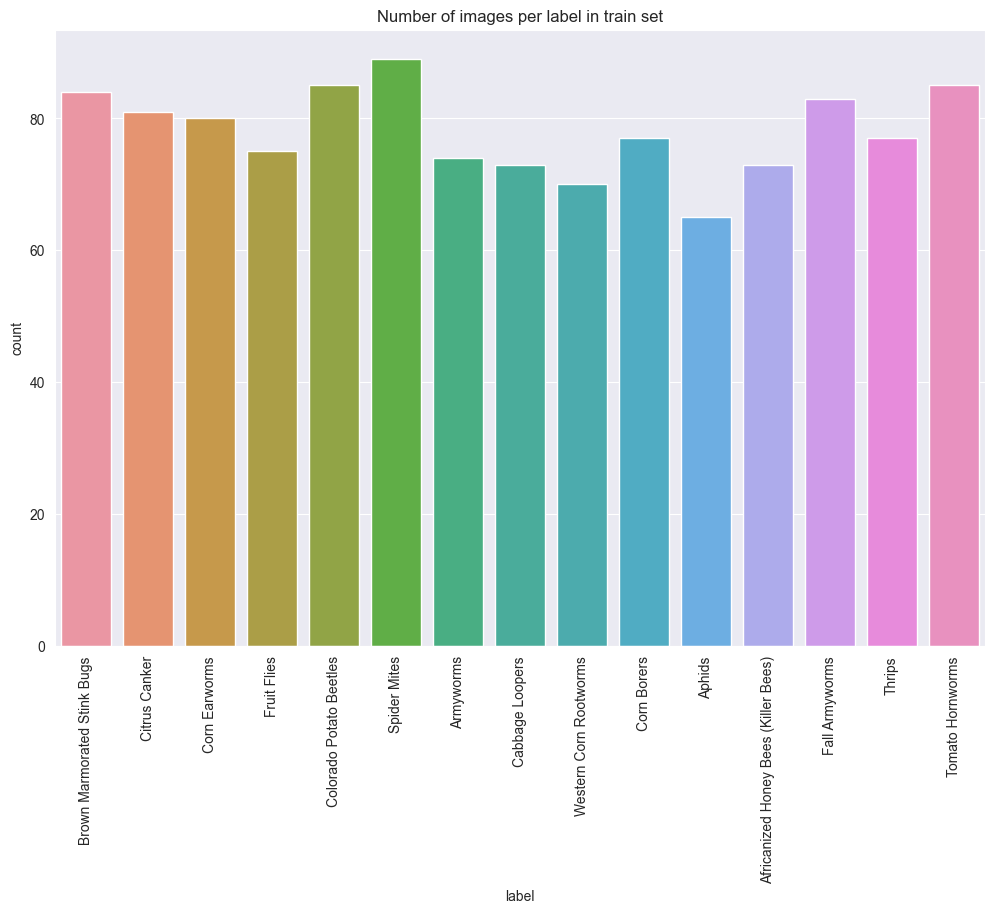

In [29]:
# Plot number of images per label in train set
plt.figure(figsize=(12, 8))
sns.countplot(x='label', data=train_df)
plt.xticks(rotation=90)
plt.title('Number of images per label in train set')
plt.show()


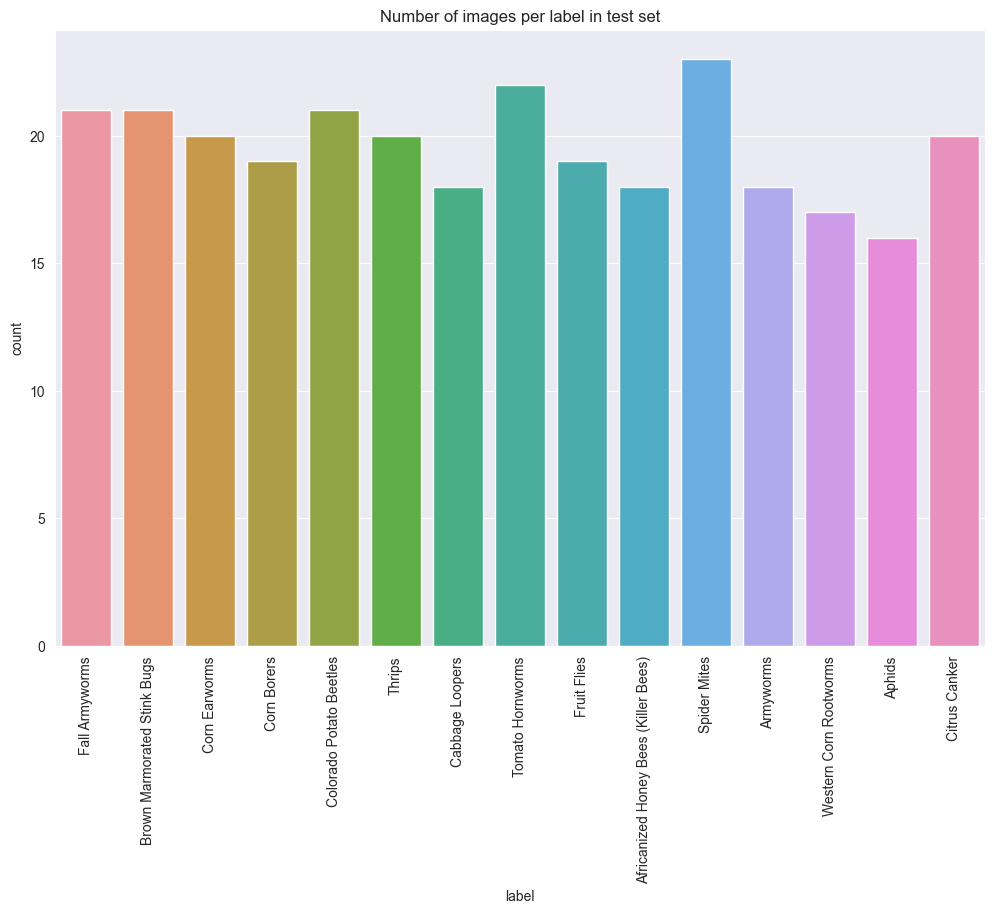

In [30]:
# Plot number of images per label in test set
plt.figure(figsize=(12, 8))
sns.countplot(x='label', data=test_df)
plt.xticks(rotation=90)
plt.title('Number of images per label in test set')
plt.show()


In [31]:
# Create validation set
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=0, stratify=train_df['label'])
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [32]:
# Define Hyperparameters
batch_size = 32
num_classes = 15
num_epochs = 10
learning_rate = 0.001

In [33]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])


In [34]:
# Create custom dataset
class InsectsDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image = Image.open(str(self.df['image'][index]))
        label = self.df['label'][index]

        if self.transform:
            image = self.transform(image)

        return image, label


In [35]:
# Create train, validation, and test datasets
train_dataset = InsectsDataset(train_df, transform=train_transforms)
val_dataset = InsectsDataset(val_df, transform=val_transforms)
test_dataset = InsectsDataset(test_df, transform=val_transforms)


In [36]:
# Create train, validation, and test dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [37]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cpu


In [40]:
# Define model
model = torchvision.models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)


C:\Users\wmigu\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\wmigu\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\wmigu/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
 22%|██▏       | 21.9M/97.8M [00:05<00:19, 4.15MB/s]


SSLError: [SSL: DECRYPTION_FAILED_OR_BAD_RECORD_MAC] decryption failed or bad record mac (_ssl.c:2548)

In [39]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


NameError: name 'model' is not defined